In [48]:
import numpy as np
from scipy.stats import beta
from scipy.special import kl_div
import matplotlib.pyplot as plt
from copy import deepcopy
import os, shutil

In [2]:
def policy(q_values, temp=None, type='softmax'):

    if temp:
        t = temp
    else:
        t = 1
    if type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    else:
        return np.array(q_values >= q_values.max()).astype(int)

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

### Construct belief tree

In [3]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0, 0)] = [1, b]

    for hi in range(1, h):
        c = 0
        if hi == 1:
            for a in range(2):
                for r in [1, 0]:
                    b1 = belief_update(b, a, r)
                    tree[hi][(a, 0, c)] = [b[a, (1-r)]/np.sum(b[a, :]), b1]
                    c += 1
        else:
            for k, v in tree[hi-1].items():
                prev_c = k[-1]
                this_b = v[1]
                proba  = v[0]
                for a in range(2):
                    for r in [1, 0]:
                        b1 = belief_update(this_b, a, r)
                        tree[hi][(a, prev_c, c)] = [proba*this_b[a, (1-r)]/np.sum(this_b[a, :]), b1]
                        c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
    v(ba^*)-v(b) =& \mathbb{E}_{b'\sim p(b'\mid b, a^*)}\Big[\sum_a \big(\pi(a\mid b')-\pi(a\mid b)\big)q(b',a) \\
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[r(b',a) - r(b,a)\big]  \\ 
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big] \Big] 
\end{align*}
$$

where $ba^*$ is a belief that results from choosing action $a^*$ from belief $b$, the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [5]:
def replay(tree, xi=0.1, weighted=True, zero_all=False):
    '''
    calculate the evb for all tree nodes
    -------
    tree: belief tree
    -------
    '''

    h         = len(tree.keys())           # planning horizon
    evb_tree  = {hi:{} for hi in range(h)} # tree with evb values for each node
    val_tree  = {hi:{} for hi in range(h)} # tree with value estimate for each node
    backups   = []

    # first assign leaf values as immediate reward at all horizons
    for hi in range(h):
        for k, b in tree[hi].items():
            if zero_all:
                if (hi == 0) or (hi == h-1):
                    this_b   = b[1]
                    q_values = np.array([this_b[0, 0]/np.sum(this_b[0, :]), this_b[1, 0]/np.sum(this_b[1, :])]) # initial q-values are just the immediate rewards
                else:
                    q_values = np.zeros(2)
            else:
                this_b   = b[1]
                q_values = np.array([this_b[0, 0]/np.sum(this_b[0, :]), this_b[1, 0]/np.sum(this_b[1, :])])
                
            val_tree[hi][k] = np.dot(policy(q_values), q_values) # change temperature?

    # then compute evb for every backup

    while True: # for N steps
        max_evb = 0

        nval_tree = {hi:{} for hi in range(h)} # tree with new updated value estimates for each node
        for hi in reversed(range(h-1)):
            for k, b in tree[hi].items():
                
                v      = val_tree[hi][k] # current value of this belief state
                this_b = b[1]
                proba  = b[0]

                c = k[-1]
                for a in range(2):
                    v_primes = []
                    for k1, v_prime in val_tree[hi+1].items():
                        prev_c = k1[-2]
                        if prev_c == c and k1[0] == a:
                            v_primes += [v_prime] # values of next belief states
                    # print(v_primes)

                    v_new = (this_b[a, 0]/np.sum(this_b[a, :]))*(1 + gamma*v_primes[0]) + (this_b[a, 1]/np.sum(this_b[a, :]))*(0 + gamma*v_primes[1])

                    new_key = tuple(list(k) + [a])

                    if weighted:
                        evb = proba*(v_new - v)
                    else:
                        evb = v_new - v
                        
                    if evb > max_evb:
                        max_evb = evb

                    evb_tree[hi][new_key]  = proba*(v_new - v)
                    nval_tree[hi][new_key] = v_new

        if max_evb < xi:
            break

        max_val = 0
        for hi in reversed(range(h-1)):
            for k, v in evb_tree[hi].items():
                if v > max_val:
                    backup  = [hi, k]
                    max_val = v
        if max_val <= 0:
            return val_tree, backups
        
        val_tree[backup[0]][backup[1][:-1]] = nval_tree[backup[0]][backup[1]]
        backups += [[tree[backup[0]][backup[1][:-1]], backup[0], backup[1]]]

    return val_tree, backups

### Initialise the agent

In [6]:
M = np.array([
    [100, 1],
    [1, 100]
])

gamma = 0.9

In [6]:
from tex_tree import generate_tex_tree, generate_big_tex_tree

h    = 3
tree = get_belief_tree(h, M)
val_tree, replays = replay(tree, weighted=False)
save_path = os.path.join('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/Tree/tex_tree_small.tex')
generate_tex_tree(M, replays, save_path)

In [34]:
M = np.array([
    [10, 5],
    [3, 1]
])

gamma = 0.9

In [35]:
from tex_tree import generate_tex_tree, generate_big_tex_tree

h    = 4
tree = get_belief_tree(h, M)
val_tree, replays = replay(tree, xi=0.3, weighted=True, zero_all=True)

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/Tree/seq/'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_big_%u.tex'%idx)
    generate_big_tex_tree(h, these_replays, save_path)

### Distribution updates asymmetry 

In [50]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = np.array([1, 1])
rv1b = beta(a1b, b1b)  

a1a, b1a = np.array([2, 1])
rv1a = beta(a1a, b1a)

a1aa, b1aa = np.array([3, 1])
rv1aa = beta(a1aa, b1aa)

33.069335223152315
9.461856116669543


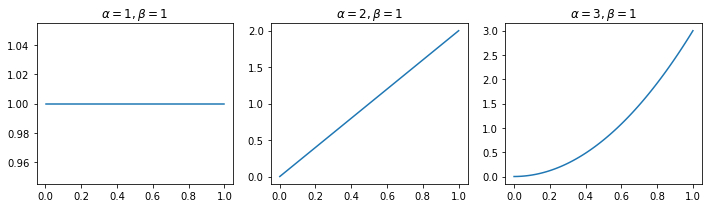

In [54]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(x, rv1b.pdf(x))
plt.title(r'$\alpha=1, \beta=1$')

plt.subplot(132)
plt.plot(x, rv1a.pdf(x))
plt.title(r'$\alpha=2, \beta=1$')

print(np.sum(kl_div(rv1b.pdf(x), rv1a.pdf(x))))

plt.subplot(133)
plt.plot(x, rv1aa.pdf(x))
plt.title(r'$\alpha=3, \beta=1$')

print(np.sum(kl_div(rv1a.pdf(x), rv1aa.pdf(x))))

plt.tight_layout()

plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')